In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import transformers
import torchtext
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import pandas as pd
import random

debug = False

print("Pytorch: \t\t", torch.__version__)
if not debug and torch.cuda.is_available():
    device='cuda'
    print('GPU:         \t\t', torch.cuda.get_device_name(0))
    print('Memory Usage:\t',
        round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB / ',
        round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    
    torch.backends.cudnn.benchmark = True
else:
    print("GPU is **not available**")
    device='cpu'

Pytorch: 		 1.10.2+cu102
GPU:         		 NVIDIA GeForce GTX 1660 Ti
Memory Usage:	 0.0 GB /  0.0 GB


In [2]:
# Initializing parameters

batch_size = 24     # Reduce this if you get memory errors

seed = 2476          # A random seed to get replicable results

sequence_max_length = 250

In [3]:
data_dir = pathlib.Path('/home/addy/datasets/aclImdb_v1/')

if data_dir.exists():
    print("Found the 'aclImdb_v1' dataset.")
else:
    print("Downloading the 'aclImdb_v1' dataset.")
    dataset_url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
    !wget {dataset_url} -P {data_dir.parent}
    !mkdir {data_dir}
    !tar xf {data_dir.parent / "aclImdb_v1.tar.gz"} -C {data_dir}
    !mv {data_dir / 'train' / 'unsup'} {data_dir / 'unsup'}
data_dir = data_dir / 'aclImdb'


Found the 'aclImdb_v1' dataset.


In [4]:
!ls {data_dir/'train'}

labeledBow.feat  pos		urls_neg.txt  urls_unsup.txt
neg		 unsupBow.feat	urls_pos.txt


In [5]:
class DFDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        self.df = dataframe

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        return tuple(self.df.iloc[index])

In [6]:
def cleanup(data):
    return data.replace('<br />', '')

test_dir = data_dir / 'test'

files = [y for y in (test_dir).glob('*/*')] 
random.shuffle(files)

num_test = len(files)//2
testdata = [(i.parent.stem, cleanup(open(i).read())) for i in files[:num_test]]
train_oracledata = [(cleanup(open(i).read()), i.parent.stem, i.stem) for i in files[num_test:]]

oracle = {i[2]:i[1] for i in train_oracledata}
assert(len([i[2] for i in train_oracledata]) == len(oracle))
train_oracledata = [(i[0], i[2]) for i in train_oracledata]

train_dir = data_dir / 'train'

files = [y for y in (train_dir).glob('*/*')] 
traindata = [(i.parent.stem, cleanup(open(i).read())) for i in files]

testdf = pd.DataFrame(testdata, columns =['cat', 'text'])
traindf = pd.DataFrame(traindata, columns =['cat', 'text'])

print(tuple(traindf.iloc[0]))
print(tuple(testdf.iloc[0]))
print(tuple(train_oracledata[0]))
len(traindf), len(testdf)

('pos', "Cypher is a movie well worth seeing because it's not the run-of-the-mill Sci-Fi flick. The artistic approach is painted with dark scenes and a kind of macro view of what's going on. The close-up camera view is how the director keeps the plot illusive. The sci-fi aspect of the movie is secondary to the plot of the movie. The technology used in the movie isn't overly impressive, however, the director makes good use of the props. The character development is intentionally shallow. The main character, Jeremy Northam, decides to immerse himself into the world of espionage. It's up to the audience to figure out his enigmatic character and it's the enigma that keeps the audience interested right to the very end.")
('neg', "I have now seen quite a few films by Pedro Almodóvar, but this would have to be the most disappointing so far. This film seemed to lack the zaniness that is usually everywhere in his films, and the story just never got me interested. Many Almodóvar regulars appear 

(25000, 12500)

In [7]:
train_dataset = DFDataset(traindf)
test_dataset = DFDataset(testdf)


In [8]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
# inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
# inputs

inputs = tokenizer.encode_plus(
                    'Hello, my dog is cute', 
                    None,
                    add_special_tokens=True,
                    max_length = 20,
                    truncation = True,
                    padding='max_length',
                    return_tensors="pt"               
                )

inputs

{'input_ids': tensor([[  101,  7592,  1010,  2026,  3899,  2003, 10140,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}

In [9]:
tokenizer.decode(inputs['input_ids'][0])

'[CLS] hello, my dog is cute [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [10]:
# dbert = transformers.DistilBertModel.from_pretrained("distilbert-base-uncased")
# res = dbert(inputs['input_ids'],inputs['attention_mask'])

In [11]:
# torch.mean(res.last_hidden_state, 1).shape

In [12]:
# print(dbert)



In [13]:
text_pipeline = lambda x: tokenizer.encode_plus(
                    x, 
                    None,
                    add_special_tokens=True,
                    max_length = sequence_max_length,
                    truncation = True,
                    padding='max_length'                    
                )
label_pipeline = lambda x: 1 if x == 'pos' else 0

In [14]:
def collate_batch(batch):
     inputs = tokenizer.batch_encode_plus(
                    [text for _, text in batch],
                    add_special_tokens=True,
                    max_length = sequence_max_length,
                    truncation = True,
                    padding='max_length',
                    return_tensors="pt"                    
               )
     input_ids = inputs['input_ids']
     attention_mask = inputs['attention_mask']

     labels = torch.tensor([label_pipeline(label) for label, _ in batch], dtype=torch.float32).unsqueeze(-1)
     return (input_ids, attention_mask), labels

In [15]:
'''
Each query strategy below returns a list of len=query_size with indices of 
samples that are to be queried.

Arguments:
- model (torch.nn.Module): not needed for `random_query`
- device (torch.device): not needed for `random_query`
- dataloader (torch.utils.data.DataLoader)
- query_size (int): number of samples to be queried for labels (default=10)

'''
def random_query(data_loader, query_size=10):
    
    sample_idx = []
    
    # Because the data has already been shuffled inside the data loader,
    # we can simply return the `query_size` first samples from it
    for batch in data_loader:
        
        _, _, idx = batch
        sample_idx.extend(idx.tolist())

        if len(sample_idx) >= query_size:
            break
    
    return sample_idx[0:query_size]

def least_confidence_query(model, device, data_loader, query_size=10):

    confidences = []
    indices = []
    
    model.eval()
    
    with torch.no_grad():
        for batch in data_loader:
        
            data, _, idx = batch
            logits = model(data.to(device))
            probabilities = F.softmax(logits, dim=1)
            
            # Keep only the top class confidence for each sample
            most_probable = torch.max(probabilities, dim=1)[0]
            confidences.extend(most_probable.cpu().tolist())
            indices.extend(idx.tolist())
            
    conf = np.asarray(confidences)
    ind = np.asarray(indices)
    sorted_pool = np.argsort(conf)
    # Return the indices corresponding to the lowest `query_size` confidences
    return ind[sorted_pool][0:query_size]

def margin_query(model, device, data_loader, query_size=10):
    
    margins = []
    indices = []
    
    model.eval()
    
    with torch.no_grad():
        for batch in data_loader:
        
            data, _, idx = batch
            logits = model(data.to(device))
            probabilities = F.softmax(logits, dim=1)
            
            # Select the top two class confidences for each sample
            toptwo = torch.topk(probabilities, 2, dim=1)[0]
            
            # Compute the margins = differences between the two top confidences
            differences = toptwo[:,0]-toptwo[:,1]
            margins.extend(torch.abs(differences).cpu().tolist())
            indices.extend(idx.tolist())

    margin = np.asarray(margins)
    index = np.asarray(indices)
    sorted_pool = np.argsort(margin)
    # Return the indices corresponding to the lowest `query_size` margins
    return index[sorted_pool][0:query_size]


In [16]:
train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    num_workers=8,
    batch_size=batch_size,
    collate_fn=collate_batch)

test_dataloader = DataLoader(
    test_dataset, 
    num_workers=8,
    batch_size=batch_size, 
    collate_fn=collate_batch)


In [17]:
class_names = ['neg','pos']
for (input_ids, attention_masks), labels in train_dataloader:
    print("Shape of input_ids: ", input_ids.shape)
    print("Shape of attention_masks: ", attention_masks.shape)
    print("Labels : ", labels.shape)
    print("SAMPLE")
    print("Label: ",class_names[int(labels[0].item())])
    print("Text:")
    print(tokenizer.decode(input_ids[0]))
    # print(X, y, o)
    break

Shape of input_ids:  torch.Size([24, 250])
Shape of attention_masks:  torch.Size([24, 250])
Labels :  torch.Size([24, 1])
SAMPLE
Label:  pos
Text:
[CLS] ah, noir. my favourite genre. otto preminger's follow - up to " laura " is a film noir set in a postwar new york, where corruption and violence run rampant. it stars dana andrews as sergeant mark dixon, a detective whose brutal tactics have landed him in hot water with his superiors. when he accidentally kills a murder suspect, dixon tries to pin the blame on crime boss tommy scalese. dixon is close to achieving his goal when he becomes involved with the dead man's wife, the beautiful morgan taylor. of course, in typical noir fashion, things quickly go down hill. while the film does nothing interesting camera or narrative wise, it does have a constant tone of dread and gloom. like most great noirs, it is also wonderfully paced, sucking the viewer in right from the start. still, like most of preminger's workmanlike films, it's not somet

In [18]:
'''
Each query strategy below returns a list of len=query_size with indices of 
samples that are to be queried.

Arguments:
- model (torch.nn.Module): not needed for `random_query`
- device (torch.device): not needed for `random_query`
- dataloader (torch.utils.data.DataLoader)
- query_size (int): number of samples to be queried for labels (default=10)

'''
def random_query(data_loader, query_size=10):
    
    sample_idx = []
    
    # Because the data has already been shuffled inside the data loader,
    # we can simply return the `query_size` first samples from it
    for batch in data_loader:
        
        _, _, idx = batch
        sample_idx.extend(idx.tolist())

        if len(sample_idx) >= query_size:
            break
    
    return sample_idx[0:query_size]

def least_confidence_query(model, device, data_loader, query_size=10):

    confidences = []
    indices = []
    
    model.eval()
    
    with torch.no_grad():
        for batch in data_loader:
        
            data, _, idx = batch
            logits = model(data.to(device))
            probabilities = F.softmax(logits, dim=1)
            
            # Keep only the top class confidence for each sample
            most_probable = torch.max(probabilities, dim=1)[0]
            confidences.extend(most_probable.cpu().tolist())
            indices.extend(idx.tolist())
            
    conf = np.asarray(confidences)
    ind = np.asarray(indices)
    sorted_pool = np.argsort(conf)
    # Return the indices corresponding to the lowest `query_size` confidences
    return ind[sorted_pool][0:query_size]

def margin_query(model, device, data_loader, query_size=10):
    
    margins = []
    indices = []
    
    model.eval()
    
    with torch.no_grad():
        for batch in data_loader:
        
            data, _, idx = batch
            logits = model(data.to(device))
            probabilities = F.softmax(logits, dim=1)
            
            # Select the top two class confidences for each sample
            toptwo = torch.topk(probabilities, 2, dim=1)[0]
            
            # Compute the margins = differences between the two top confidences
            differences = toptwo[:,0]-toptwo[:,1]
            margins.extend(torch.abs(differences).cpu().tolist())
            indices.extend(idx.tolist())

    margin = np.asarray(margins)
    index = np.asarray(indices)
    sorted_pool = np.argsort(margin)
    # Return the indices corresponding to the lowest `query_size` margins
    return index[sorted_pool][0:query_size]


In [19]:
from torch import nn

class ClassifyNet(nn.Module):

    def __init__(self, num_class):
        super().__init__()
        self.dbert = transformers.DistilBertModel.from_pretrained("distilbert-base-uncased")
        # modules = [self.dbert.embeddings, *self.dbert.transformer.layer[:6]] #Replace 5 by what you want
        # for module in modules:
        #     for param in module.parameters():
        #         param.requires_grad = False

        self.fc = nn.Linear(768, num_class)
        self.dropout = nn.Dropout(0.5)

    def forward(self, input_ids, attention_mask):
        x = self.dbert(input_ids, attention_mask)
        x = torch.mean(x.last_hidden_state, 1)
        
        x = self.dropout(x)
        # print(x.shape)
        x = self.fc(x)

        return torch.sigmoid(x)

In [20]:
a = torch.randn(32, 250, 16)
torch.mean(a, 1).shape

torch.Size([32, 16])

In [21]:
def train_loop(dataloader, model, loss_fn, optimizer, history, epoch):
    size = len(dataloader.dataset)
    accuracy = 0

    with tqdm(dataloader, unit="batch") as dl:
        for ((input_ids, attention_mask), y) in dl:
            dl.set_description(f"Training epoch {epoch}")

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            y = y.to(device)

            #FORWARD PASS
            pred = model(input_ids, attention_mask)
            loss = loss_fn(pred, y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss = loss.item()
            accuracy += (torch.round(pred) == y).type(torch.float).sum().item()

            # if batch % 100 == 0:
            #     loss, current = loss.item(), batch * len(X)
            #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    accuracy /= size
    history['train_loss'].append(loss)
    history['train_accuracy'].append(accuracy)
    return loss, accuracy


def test_loop(dataloader, model, loss_fn, history):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, accuracy = 0, 0

    with torch.no_grad():
        with tqdm(dataloader, unit="batch") as dl:
            for ((input_ids, attention_mask), y) in dl:
                dl.set_description(f"Testing epoch {epoch}")   

                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                y = y.to(device)


                pred = model(input_ids, attention_mask)
                
                loss += loss_fn(pred, y).item()
                accuracy += (torch.round(pred) == y).type(torch.float).sum().item()

    loss /= num_batches
    accuracy /= size

    history['test_loss'].append(loss)
    history['test_accuracy'].append(accuracy)
    return loss, accuracy

In [22]:
emsize = 16
num_classes = 1

model = ClassifyNet(num_classes).to(device)
    
loss_fn = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)



Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [23]:
print(model)

ClassifyNet(
  (dbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_featur

In [24]:
count = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {count}")

Number of trainable parameters: 66363649


In [25]:
epochs = 5
history = {
    'train_loss':[],
    'train_accuracy':[],
    'test_loss':[],
    'test_accuracy':[]
}

for epoch in range(epochs):
    train_loop(train_dataloader, model, loss_fn, optimizer, history, epoch)
    test_loop(test_dataloader, model, loss_fn, history)

# Base model has 66363649 parameters
# 786.82s/epoch (11 minutes)

Testing epoch 4: 100%|██████████| 521/521 [02:19<00:00,  3.72batch/s]


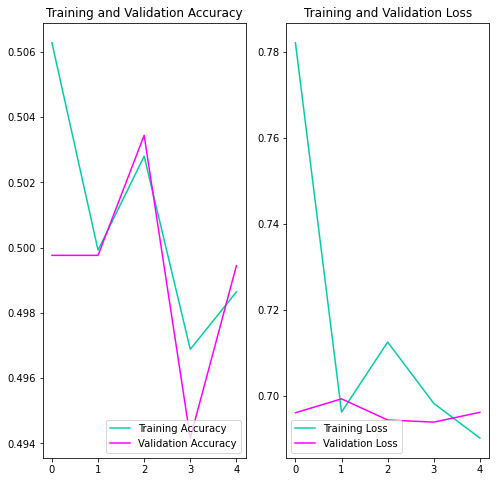

In [26]:
epochs_range = range(len(history['train_accuracy']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_accuracy'], label='Training Accuracy', color='#03CEA4')
plt.plot(epochs_range, history['test_accuracy'], label='Validation Accuracy', color='#fc00ff')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['train_loss'], label='Training Loss', color='#03CEA4')
plt.plot(epochs_range, history['test_loss'], label='Validation Loss', color='#fc00ff')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')
plt.show()
